In [1]:
import torch
import random
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import numpy as np
import pandas as pd

train = pd.read_csv('train.csv')
dev = pd.read_csv('val.csv')
train = train.dropna()
dev = dev.dropna()

train['text'] = train['text'].astype(str)
#train['label'] = 1
X_train = train['text']
y_train = train["label"]

dev['text'] = dev['text'].astype(str)
X_valid = dev['text']
y_valid = dev['label']

In [3]:
import pandas as pd

train_sentences = list(train['text'].values)
train_labels = list(train['label'].values)

dev_sentences = list(dev['text'].values)
dev_labels = list(dev['label'].values)

In [4]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_labels)
encoded_labels = le.transform(train_labels)
encoded_dev_labels = le.transform(dev_labels)

In [4]:
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base-v2')
phoBert = AutoModel.from_pretrained('vinai/phobert-base-v2')

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tqdm import tqdm
def encoder_generator(sentences,labels):


    sent_index1 = []
    sent_index2 = []
    input_ids = []
    attention_masks = []
    decoder_labels = []
    tokenizer.pad_token = tokenizer.eos_token
    for index, sent in enumerate(tqdm(sentences)):
        sent_index1.append(index)

        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'].to(device))
        attention_masks.append(encoded_dict['attention_mask'].to(device))
    # Concatenate and move final tensors to the GPU
    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)
    #decoder_labels = torch.cat(decoder_labels,dim=0).to(device)
    labels = torch.tensor(labels).to(device)
    sent_index1 = torch.tensor(sent_index1).to(device)
    
    return sent_index1, input_ids, attention_masks, labels

train_sent_index,train_input_ids,train_attention_masks,train_encoded_label_tensors = encoder_generator(train_sentences,train_labels)
dev_sent_index,dev_input_ids,dev_attention_masks,dev_encoded_label_tensors = encoder_generator(dev_sentences,dev_labels)
#print('Original: ', train_sentences[0])
#print('Token IDs:', train_input_ids[0])


  0%|          | 0/43171 [00:00<?, ?it/s]/workspace/thviet/LLMs/Monolingual/drop-rag/.conda/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2829: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 5382/5382 [00:01<00:00, 2837.68it/s]


In [15]:
print('Token IDs:', train_input_ids[0])

Token IDs: tensor([    0,   266,  6344, 18150,  1204,    88,   238,   118,    17,  7708,
            3,  3965,   344,   988,    77,    59,  6205,  6266,     6,  7130,
        45572,  1301,     4,    59,  1061, 41086,     6,    17,    10,    61,
        14457,  9970,    12, 27772,     4,    15,   139,    47,   939,   520,
        10793,  5796,  1384,     4,   122,    13,    18,   305,  4263,   154,
           11,    61,    72,  2270,  1494, 39951,  1494, 39951,    59,  1088,
        42245, 13208,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,    

In [ ]:
print('Original: ', train_sentences[:10])
print('Token IDs:', train_input_ids[:10])

In [7]:
# Connvert train, dev input by using TensorDataset

from torch.utils.data import TensorDataset,random_split

train_dataset = TensorDataset(train_input_ids,train_encoded_label_tensors,train_attention_masks)
#train_attention_masks,
dev_dataset = TensorDataset(dev_input_ids,dev_encoded_label_tensors,dev_attention_masks)
#,dev_attention_masks

print('train data samples is {}'.format(len(train_dataset)))
print("valid data samples is {}".format(len(dev_dataset)))

train data samples is 43171
valid data samples is 5382


In [ ]:
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

bs=32

train_data_loader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=bs)
valid_data_loader = DataLoader(dev_dataset,
                              sampler=RandomSampler(dev_dataset),
                              batch_size=bs)

In [12]:
import joblib
joblib.dump(train_data_loader, '/workspace/thviet/LLMs/Monolingual/train_data_loader.pkl')
joblib.dump(valid_data_loader, '/workspace/thviet/LLMs/Monolingual/val_data_loader.pkl')

['/workspace/thviet/LLMs/Monolingual/val_data_loader.pkl']

In [17]:
joblib.dump(test_data_loader, '/workspace/thviet/LLMs/Monolingual/toxic/test_data_loader.pkl')

['/workspace/thviet/LLMs/Monolingual/toxic/test_data_loader.pkl']

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class BCNN(nn.Module):
    def __init__(self, embedding_dim, output_dim,
                 dropout,bidirectional_units,conv_filters):

        super().__init__()
        self.bert = phoBert
        #.fc_input = nn.Linear(embedding_dim,embedding_dim)
        self.bidirectional_lstm = nn.LSTM(
            embedding_dim, bidirectional_units, bidirectional=True, batch_first=True
        )
        self.conv1 = nn.Conv1d(in_channels=2*bidirectional_units, out_channels=conv_filters[0], kernel_size=4)
        self.conv2 = nn.Conv1d(in_channels=2*bidirectional_units, out_channels=conv_filters[1], kernel_size=5)

        self.fc = nn.Linear(64, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,b_input_ids,b_input_mask):
        encoded = self.bert(b_input_ids,b_input_mask)[0]
        embedded, _ = self.bidirectional_lstm(encoded)
        embedded = embedded.permute(0, 2, 1)
        conved_1 = F.relu(self.conv1(embedded))
        conved_2 = F.relu(self.conv2(embedded))
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        #pooled_n = [batch size, n_fibatlters]

        cat = self.dropout(torch.cat((pooled_1, pooled_2), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]

        result =  self.fc(cat)

        return result

In [5]:
# Hyperparameters

EMBEDDING_DIM = 768
OUTPUT_DIM = 2
DROPOUT = 0.1
CONV_FILTERS = [32, 32]  # Number of filters for each kernel size (4 and 5)
BIDIRECTIONAL_UNITS = 128
cnn = BCNN(EMBEDDING_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL_UNITS, CONV_FILTERS)
#cnn = cnn.to(device)

Thiết lập optimizer Adam cho mô hình, kết hợp các tham số từ cả PhoBERT và CNN.
 Khởi tạo hàm mất mát Cross Entropy, thường được sử dụng cho các bài toán phân loại đa lớp.
Hàm mất mát cũng được chuyển sang thiết bị tính toán để sẵn sàng cho quá trình huấn luyện.

In [12]:
import torch.optim as optim

model_prameters = list(cnn.parameters())

optimizer = optim.Adam(model_prameters,lr=2e-5,eps=1e-8)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [9]:
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)  # Lấy chỉ số của xác suất cao nhất
    correct = max_preds.squeeze(1).eq(y.to(preds.device))  # Đảm bảo y nằm cùng thiết bị với preds
    return correct.sum() / torch.FloatTensor([y.shape[0]]).to(preds.device)  # Đảm bảo tất cả tensor nằm cùng thiết bị

In [14]:
# Def for training

from tqdm import tqdm

def train():

    epoch_loss = 0
    epoch_acc = 0

    phoBert.train()
    cnn.train()
    for batch in tqdm(train_data_loader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        optimizer.zero_grad()

        predictions = cnn(b_input_ids,b_input_mask)
        #, decoder_input_ids=b_labels
        #hidden_states = outputs.hidden_states
        #embedded = hidden_states[-1]
        '''predictions = cnn(outputs)'''

        loss = criterion(predictions, b_labels)
        #.long()

        acc = categorical_accuracy(predictions, b_labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_data_loader), epoch_acc / len(train_data_loader)

In [6]:
# Class for predict label

import numpy as np

def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

In [7]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
def eval():
    epoch_loss = 0

    total_predictions = []
    total_true = []

    all_true_labels = []
    all_pred_labels = []
    cnn.eval()

    with torch.no_grad():

        for batch in tqdm(valid_data_loader):
            b_input_ids = batch[0].to(device)
            b_labels = batch[1].to(device)
            b_input_mask = batch[2].to(device)
           

            predictions = cnn(b_input_ids,b_input_mask)
            #hidden_states = outputs.hidden_states
            #embedded = outputs.encoder_last_hidden_state
            ''' predictions = cnn(outputs)'''

            loss = criterion(predictions, b_labels)
            #.long()
            epoch_loss += loss.item()

            predictions = predictions.detach().cpu().numpy()

            label_ids = b_labels.to('cpu').numpy()

            pred,true = predictions_labels(predictions,label_ids)

            all_pred_labels.extend(pred)
            all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    macro_f1_score = f1_score(all_pred_labels,all_true_labels,average='macro')

    avg_val_loss = epoch_loss/len(valid_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))
    return avg_val_loss,avg_val_accuracy,macro_f1_score

In [8]:
# Time for training

import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
epochs = 10

best_macro_f1 = float('0')
#phoBert.to(device)
for epoch in range(epochs):

    start_time = time.time()
    train_loss,train_acc = train()
    valid_loss,valid_acc,macro_f1 = eval()
    end_time = time.time()


    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        #torch.save(phoBert,'phobert.pt')
        torch.save(cnn,'toxic.pt')
        print("model saved")

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. acc: {valid_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {macro_f1*100:.2f}%')
    print('=============Epoch Ended==============')

100%|██████████| 169/169 [00:11<00:00, 14.12it/s]


              precision    recall  f1-score   support

           0       0.96      0.87      0.91      4376
           1       0.60      0.86      0.71      1006

    accuracy                           0.87      5382
   macro avg       0.78      0.86      0.81      5382
weighted avg       0.90      0.87      0.87      5382

accuracy = 0.87
model saved
Epoch: 01 | Epoch Time: 4m 45s
	Train Loss: 0.383 | Train acc: 83.90%
	 Val. Loss: 0.342 |  Val. acc: 86.58%
	 Val. Loss: 0.342 |  Val. F1: 80.92%
=============Epoch Ended==============


100%|██████████| 169/169 [00:12<00:00, 13.76it/s]


              precision    recall  f1-score   support

           0       0.94      0.90      0.92      4106
           1       0.71      0.81      0.76      1276

    accuracy                           0.88      5382
   macro avg       0.83      0.85      0.84      5382
weighted avg       0.89      0.88      0.88      5382

accuracy = 0.88
model saved
Epoch: 02 | Epoch Time: 4m 56s
	Train Loss: 0.288 | Train acc: 88.23%
	 Val. Loss: 0.310 |  Val. acc: 87.81%
	 Val. Loss: 0.310 |  Val. F1: 83.86%
=============Epoch Ended==============


100%|██████████| 169/169 [00:12<00:00, 14.02it/s]


              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3776
           1       0.79      0.71      0.75      1606

    accuracy                           0.86      5382
   macro avg       0.83      0.81      0.82      5382
weighted avg       0.85      0.86      0.85      5382

accuracy = 0.86
Epoch: 03 | Epoch Time: 4m 54s
	Train Loss: 0.230 | Train acc: 90.98%
	 Val. Loss: 0.351 |  Val. acc: 85.62%
	 Val. Loss: 0.351 |  Val. F1: 82.29%
=============Epoch Ended==============


100%|██████████| 169/169 [00:12<00:00, 13.89it/s]


              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3960
           1       0.74      0.75      0.75      1422

    accuracy                           0.86      5382
   macro avg       0.83      0.83      0.83      5382
weighted avg       0.87      0.86      0.87      5382

accuracy = 0.86
Epoch: 04 | Epoch Time: 4m 57s
	Train Loss: 0.183 | Train acc: 92.82%
	 Val. Loss: 0.347 |  Val. acc: 86.47%
	 Val. Loss: 0.347 |  Val. F1: 82.69%
=============Epoch Ended==============


100%|██████████| 169/169 [00:11<00:00, 14.14it/s]


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4005
           1       0.73      0.77      0.75      1377

    accuracy                           0.87      5382
   macro avg       0.83      0.84      0.83      5382
weighted avg       0.87      0.87      0.87      5382

accuracy = 0.87
Epoch: 05 | Epoch Time: 4m 55s
	Train Loss: 0.138 | Train acc: 94.87%
	 Val. Loss: 0.380 |  Val. acc: 87.01%
	 Val. Loss: 0.380 |  Val. F1: 83.21%
=============Epoch Ended==============


100%|██████████| 169/169 [00:12<00:00, 13.75it/s]


              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4005
           1       0.72      0.76      0.74      1377

    accuracy                           0.86      5382
   macro avg       0.82      0.83      0.82      5382
weighted avg       0.86      0.86      0.86      5382

accuracy = 0.86
Epoch: 06 | Epoch Time: 4m 56s
	Train Loss: 0.105 | Train acc: 96.15%
	 Val. Loss: 0.485 |  Val. acc: 86.23%
	 Val. Loss: 0.485 |  Val. F1: 82.20%
=============Epoch Ended==============


100%|██████████| 169/169 [00:12<00:00, 13.89it/s]


              precision    recall  f1-score   support

           0       0.92      0.89      0.91      4092
           1       0.68      0.76      0.72      1290

    accuracy                           0.86      5382
   macro avg       0.80      0.83      0.81      5382
weighted avg       0.87      0.86      0.86      5382

accuracy = 0.86
Epoch: 07 | Epoch Time: 4m 59s
	Train Loss: 0.085 | Train acc: 96.93%
	 Val. Loss: 0.560 |  Val. acc: 85.84%
	 Val. Loss: 0.560 |  Val. F1: 81.32%
=============Epoch Ended==============


100%|██████████| 169/169 [00:12<00:00, 14.03it/s]


              precision    recall  f1-score   support

           0       0.92      0.89      0.90      4047
           1       0.69      0.75      0.72      1335

    accuracy                           0.86      5382
   macro avg       0.80      0.82      0.81      5382
weighted avg       0.86      0.86      0.86      5382

accuracy = 0.86
Epoch: 08 | Epoch Time: 4m 55s
	Train Loss: 0.064 | Train acc: 97.74%
	 Val. Loss: 0.573 |  Val. acc: 85.60%
	 Val. Loss: 0.573 |  Val. F1: 81.20%
=============Epoch Ended==============


100%|██████████| 169/169 [00:12<00:00, 14.07it/s]


              precision    recall  f1-score   support

           0       0.92      0.89      0.91      4081
           1       0.70      0.77      0.73      1301

    accuracy                           0.86      5382
   macro avg       0.81      0.83      0.82      5382
weighted avg       0.87      0.86      0.87      5382

accuracy = 0.86
Epoch: 09 | Epoch Time: 4m 56s
	Train Loss: 0.057 | Train acc: 98.00%
	 Val. Loss: 0.650 |  Val. acc: 86.31%
	 Val. Loss: 0.650 |  Val. F1: 81.98%
=============Epoch Ended==============


100%|██████████| 169/169 [00:11<00:00, 14.38it/s]


              precision    recall  f1-score   support

           0       0.93      0.89      0.91      4098
           1       0.69      0.78      0.73      1284

    accuracy                           0.86      5382
   macro avg       0.81      0.83      0.82      5382
weighted avg       0.87      0.86      0.87      5382

accuracy = 0.86
Epoch: 10 | Epoch Time: 4m 55s
	Train Loss: 0.045 | Train acc: 98.45%
	 Val. Loss: 0.706 |  Val. acc: 86.36%
	 Val. Loss: 0.706 |  Val. F1: 81.98%
=============Epoch Ended==============


In [12]:
cnn = torch.load(r'toxic.pt')

/tmp/ipykernel_244037/1756912611.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn = torch.load(r'toxic.pt')


In [13]:
cnn.to(device)

BCNN(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((76

In [10]:
import pandas as pd
test = pd.read_csv('test.csv')


In [11]:
test = test.dropna()
X_test = test['text']
y_test = test['label']
test_sentences = list(test['text'].values)
test_labels = list(test['label'].values)


In [14]:
from tqdm import tqdm
def encoder_generator(sentences,labels):


    sent_index1 = []
    sent_index2 = []
    input_ids = []
    attention_masks = []
    decoder_labels = []
    tokenizer.pad_token = tokenizer.eos_token
    for index, sent in enumerate(tqdm(sentences)):
        sent_index1.append(index)

        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'].to(device))
        attention_masks.append(encoded_dict['attention_mask'].to(device))
    # Concatenate and move final tensors to the GPU
    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)
    #decoder_labels = torch.cat(decoder_labels,dim=0).to(device)
    labels = torch.tensor(labels).to(device)
    sent_index1 = torch.tensor(sent_index1).to(device)
    
    return sent_index1, input_ids, attention_masks, labels

In [16]:
from torch.utils.data import TensorDataset,random_split,DataLoader,RandomSampler
test_sent_index, test_input_ids, test_attention_masks, test_encoded_label_tensors = encoder_generator(test_sentences,test_labels)
test_dataset = TensorDataset(test_input_ids,test_encoded_label_tensors,test_attention_masks)
test_data_loader = DataLoader(test_dataset,
                              sampler=RandomSampler(test_dataset),
                              batch_size=32)

100%|██████████| 5382/5382 [00:01<00:00, 3375.42it/s]


In [18]:
all_pred_labels = []
all_true_labels = []

with torch.no_grad():
  for batch in tqdm(test_data_loader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[2].to(device)
    b_labels = batch[1].to(device)
    predictions = cnn(b_input_ids,b_input_mask)
    


    predictions = predictions.detach().cpu().numpy()

    label_ids = b_labels.to('cpu').numpy()

    pred, true = predictions_labels(predictions, label_ids)

    all_pred_labels.extend(pred)
    all_true_labels.extend(true)

100%|██████████| 169/169 [00:11<00:00, 15.30it/s]


In [26]:
# The final score in the test set (classification report)

print(classification_report(all_pred_labels,all_true_labels, digits = 4))

              precision    recall  f1-score   support

           0     0.9405    0.8978    0.9187      4140
           1     0.7042    0.8108    0.7537      1242

    accuracy                         0.8777      5382
   macro avg     0.8224    0.8543    0.8362      5382
weighted avg     0.8860    0.8777    0.8806      5382



In [19]:
evaluation = f1_score(all_true_labels, all_pred_labels, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(all_true_labels, all_pred_labels, average='macro')
print("F1 - macro: " + str(evaluation))

F1 - micro: 0.8777406168710516
F1 - macro: 0.8362138180386631


<Axes: >

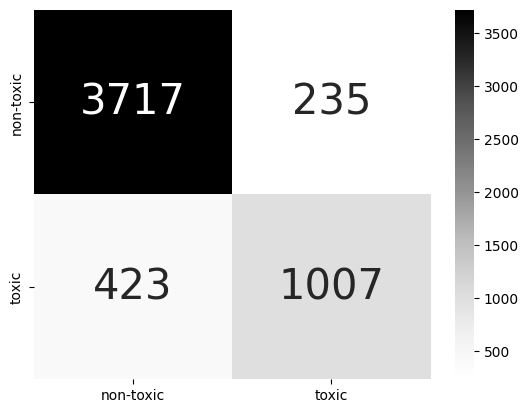

In [20]:
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
# Import the confusion_matrix function from sklearn.metrics
from sklearn.metrics import confusion_matrix
cf1 = confusion_matrix(all_true_labels, all_pred_labels)
df_cm1 = pd.DataFrame(cf1, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})